In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib 

In [2]:
df = pd.read_csv("../data/raw_data.csv")

C:\Users\sarap\AppData\Local\Temp\ipykernel_7424\3407229622.py:1: DtypeWarning: Columns (28,30,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw_data.csv")


In [3]:
df.head(5)

,collected_at,backers_count,blurb,category_id,category_name,category_parent_id,category_parent_name,category_url,converted_pledged_amount,country,...,profile_state_changed_at,project_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_exchange_rate,usd_pledged,usd_type
0,202505,185341,A Year of Sanderson: Enjoy books and swag boxe...,47.0,Fiction,18,Publishing,http://www.kickstarter.com/discover/categories...,41754153.0,US,...,1.648768e+09,https://www.kickstarter.com/projects/dragonste...,True,True,successful,1648767600,1.0,1.0,41754153.24,domestic
1,202505,78471,Color e-paper smartwatch with up to 7 days of ...,28.0,Product Design,7,Design,http://www.kickstarter.com/discover/categories...,20338986.0,US,...,1.427590e+09,https://www.kickstarter.com/projects/getpebble...,True,True,successful,1427508015,1.0,1.0,20338986.27,domestic
2,202505,55106,Beginning with The Stormlight Archive and expa...,34.0,Tabletop Games,12,Games,http://www.kickstarter.com/discover/categories...,15149874.0,US,...,1.726001e+09,https://www.kickstarter.com/projects/brotherwi...,True,True,successful,1724986800,1.0,1.0,15149874.00,domestic
3,202505,62642,The COOLEST is a portable party disguised as a...,28.0,Product Design,7,Design,http://www.kickstarter.com/discover/categories...,13285226.0,US,...,1.428101e+09,https://www.kickstarter.com/projects/ryangrepp...,True,False,successful,1409360410,1.0,1.0,13285226.36,domestic
4,202505,83193,Euro-inspired dungeon crawling sequel to the 2...,34.0,Tabletop Games,12,Games,http://www.kickstarter.com/discover/categories...,12969608.0,US,...,1.588367e+09,https://www.kickstarter.com/projects/frosthave...,True,True,successful,1588366800,1.0,1.0,12969608.00,domestic


In [4]:
### columns names and types 

df.dtypes

collected_at                  int64
backers_count                 int64
blurb                        object
category_id                 float64
category_name                object
category_parent_id            int64
category_parent_name         object
category_url                 object
converted_pledged_amount    float64
country                      object
created_at                    int64
creator_id                    int64
creator_name                 object
creator_url                  object
currency                     object
deadline                      int64
fx_rate                     float64
goal                        float64
id                            int64
launched_at                   int64
location_country             object
location_id                 float64
location_name                object
location_state               object
location_type                object
name                         object
percent_funded              float64
pledged                     

### Piilotettavia sarakkeita (vuotoriski)
- **backer_count**, koska kertoo kuinka monta tukijaa projekti sai
- **pledgeg**, koska kertoo suoraan paikallisen valuutan mukaisen luvatun summan projektille
- **usd_pledgeg**, koska kertoo usd kurssiksi muutetun luvatun summan projektille
- **spotlight** ja **staff_pick**
- **state_changed_at** viittaa projektin muuttuneeseen tilaan esim. successful, failed --> vihjaa milloin projekti päättyi.

### Poistettavia sarakkeita
- **fx_rate**, **usd_exchange_rate**, **static_usd_rate**. **usd_type** 

### Muita nostoja
- fx_rate? valuuttakurssi ilmeisimmin, jonka avulla paikallisen valuutan summat voisi muuttaa USD? tästä ilmeisimmin muodostunut sarake usd_plegded?
- usd_exchange_rate kuvaa hetkellisen valuu
- Jos lähdemme jatkossa tekemään blurb niin miten käsitellään tyhjät blurbit? Opettaja vihajsi Naive Bayesia blurbien käsittelyyn, tarkastettu että sen voi yhdistää toiseen malliin. 

### Valuutta?
- **goal** voisi muuntaa usd_goaliksi, jonka voisi laskea usd_exchange_rate, joka ilmaisee sen hetkisen kurssin ja puuttuvat arvot voisi korvata fx_ratella. Logaritmi muunnoksella vinouman vähentäminen. 

In [5]:
# Erilliset arvot per sarake

df.nunique().sort_values()

usd_type                         2
staff_pick                       2
spotlight                        2
profile_state                    2
state                            7
location_type                    9
currency                        15
category_parent_id              15
category_parent_name            16
country                         25
collected_at                   120
category_id                    156
category_url                   171
category_name                  219
location_country               223
location_state                1632
fx_rate                       1777
backers_count                 6026
goal                         13428
location_name                23463
location_id                  28830
usd_exchange_rate            29087
static_usd_rate              29617
converted_pledged_amount     60936
profile_blurb                93630
profile_name                 95323
pledged                     110882
percent_funded              200774
usd_pledged         

### Projektien kestot
- Nähtävissä, että minimi arvo projektin kestolle on 0 ja maximi 20249 päivää, joten selkeitä outliereita. Pitäisikö näitä siivota pois, jotka ovat todella ääripäitä?
- Ne missä puuttuu pelkästään toinen arvoista (launched_at tai deadline) voisi puuttuvan arvon laskea hyödyntäen mediaania tai keskiarvoa. Ylhäällä nähtävissä, että molemmat ovat suhteellisen tasalaatuiset. 

count    629147.000000
mean         51.932949
std         604.662684
min           0.000000
25%          29.000000
50%          30.000000
75%          36.000000
max       20249.000000
Name: duration_days, dtype: float64


<Axes: ylabel='Frequency'>

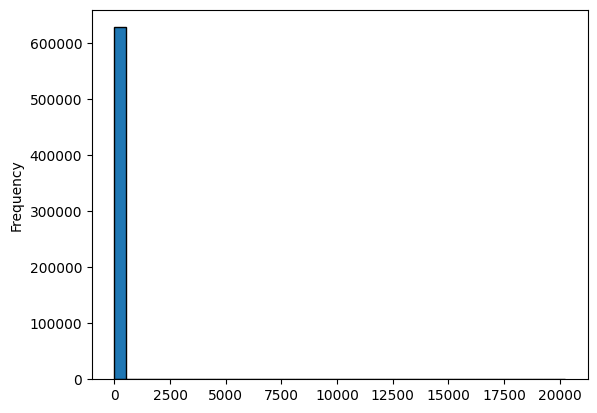

In [6]:
# Muunna aikaleimat  datetime-muotoon
df["launched_at"] = pd.to_datetime(df["launched_at"], unit="s", utc=True)
df["deadline"]    = pd.to_datetime(df["deadline"],    unit="s", utc=True)

# Laske kesto päivinä
df["duration_days"] = (df["deadline"] - df["launched_at"]).dt.days

# Tarkista arvot
print(df["duration_days"].describe())

# Piirrä histogrammi, rajattu päiviä (koska x akseli venyi 0–20000 ja Y jopa 600k. 
df["duration_days"].plot.hist(bins=40, edgecolor='black')

In [7]:
### Minimi ja maximi arvot projektien kestoille
df["duration_days"].min(), df["duration_days"].max()

(np.int64(0), np.int64(20249))

In [8]:
### Kymmenen lyhintä kestoa

df.sort_values("duration_days").head(10)[["launched_at", "deadline", "duration_days"]]

,launched_at,deadline,duration_days
629139,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629094,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629095,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629096,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629097,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629098,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629092,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629145,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629144,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0
629083,1970-01-01 00:00:00+00:00,1970-01-01 00:00:00+00:00,0


In [9]:
df.sort_values("duration_days", ascending=False).head(10)[["launched_at", "deadline", "duration_days"]]

,launched_at,deadline,duration_days
626059,1970-01-01 00:00:00+00:00,2025-06-10 05:59:00+00:00,20249
624563,1970-01-01 00:00:00+00:00,2025-06-10 18:00:00+00:00,20249
625546,1970-01-01 00:00:00+00:00,2025-06-09 01:22:00+00:00,20248
625448,1970-01-01 00:00:00+00:00,2025-06-09 21:59:00+00:00,20248
622647,1970-01-01 00:00:00+00:00,2025-06-08 21:59:00+00:00,20247
622633,1970-01-01 00:00:00+00:00,2025-06-07 04:59:00+00:00,20246
622519,1970-01-01 00:00:00+00:00,2025-06-05 03:59:00+00:00,20244
625249,1970-01-01 00:00:00+00:00,2025-06-04 02:30:00+00:00,20243
628111,1970-01-01 00:00:00+00:00,2025-06-03 13:33:00+00:00,20242
624656,1970-01-01 00:00:00+00:00,2025-06-02 01:00:00+00:00,20241


In [10]:
df["launched_at"].min(), df["launched_at"].max()

(Timestamp('1970-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2025-04-12 12:01:35+0000', tz='UTC'))

In [11]:
nollat = pd.Timestamp("1970-01-01", tz="UTC")
nollat = (df["launched_at"] == nollat).sum()
nollat

np.int64(7842)

In [12]:
mask = df["duration_days"].between(1, 60, inclusive="both") & df["duration_days"].notna()

median_1_60 = df.loc[mask, "duration_days"].median()
mean_1_60 = df.loc[mask, "duration_days"].mean()

print(median_1_60)
print(mean_1_60)

30.0
33.25198574354613


### Projektien rahoitus 
- Osassa projektissa rahoitus on 0, joka on selkeästi virheellinen. Mitä tehdään? Järkevintä voisi olla pudottaa pois nämä rivit.
- Todella suuret rahoitukset olivat esim. japanin valuuttaa. 

In [13]:
df[["goal"]].describe() 

,goal
count,6.291470e+05
mean,5.170823e+04
std,2.101302e+06
min,0.000000e+00
25%,1.500000e+03
50%,5.000000e+03
75%,1.500000e+04
max,1.000000e+09


### Luokat ja niiden jakaumat
- Liven voisi dropata pois (koska käynnissä oleva) tai sitten miettiä voisiko live statella olevat yhdistää koulutusdataan (ei voisi viedä testidataan staten takia)
- Failediin voisi yhdistää canceled mahdollisesti (koska epäonnistunuthan sekin on)
- Blurbin kielet voisi olla hyvä tarkistaa, jos se otetaan mukaan jossakin vaiheessa.

In [14]:
df["state"].value_counts()

state
successful    271076
failed        265246
canceled       60252
live           23395
submitted       7003
suspended       1351
started          824
Name: count, dtype: int64

In [15]:
df["category_parent_name"].value_counts()

category_parent_name
Games           95316
Film & Video    85846
Publishing      67038
Music           65754
Design          55671
Technology      53333
Art             51429
Fashion         39350
Food            33498
Comics          29358
Photography     13797
Theater         13202
Crafts          12972
Journalism       6474
Dance            4513
comics           1596
Name: count, dtype: int64

In [16]:
df["blurb_len"] = df["blurb"].astype(str).str.len()
df["blurb_len"].describe()

count    629147.000000
mean        106.408035
std          31.200866
min           1.000000
25%          88.000000
50%         119.000000
75%         131.000000
max         239.000000
Name: blurb_len, dtype: float64

### Kuvaajat projektien määristä ja niiden state jakaumista 
- Nähtävissä, että 0 arvot luovat hieman vinksahtanutta maisemaa

<Axes: title={'center': 'Projektien määrä / vuosi'}, xlabel='launch_year'>

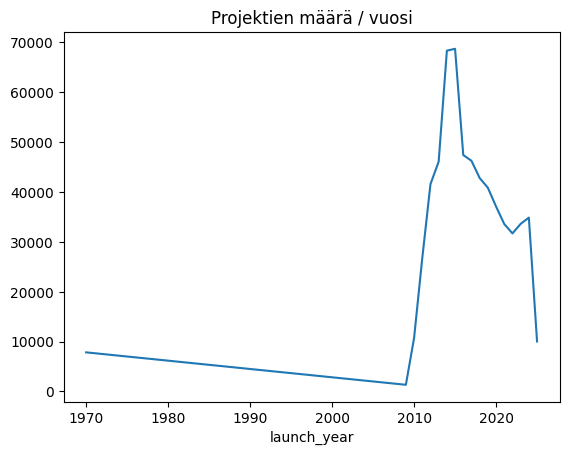

In [17]:
df["launch_year"] = df["launched_at"].dt.year
df.groupby("launch_year")["id"].count().plot(title="Projektien määrä / vuosi")

<Axes: xlabel='launch_year'>

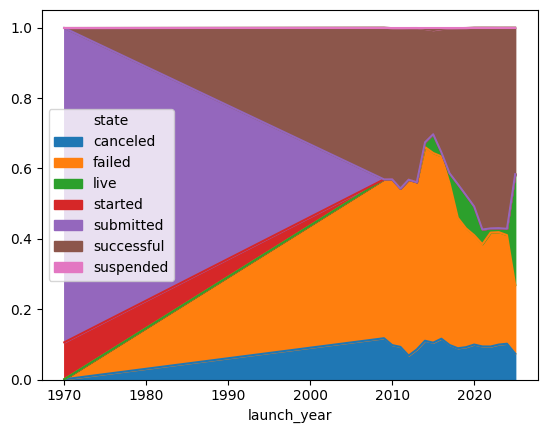

In [18]:
df.groupby("launch_year")["state"].value_counts(normalize=True).unstack().plot.area()


### Valuuttakurssit 

- static_usd_rate ei ole staattinen nimestään huolimatta ja käyttäytyy samalla tavalla kuin usd_exhange_rate
- usd_static_rate on käytetty usd_plegded laskentaan, joka muuttaisi ajatusta aiemmasta ja tukisi sitä, että sitä olisi varmin käyttää myös meidän valuuttamuunnokseen. 

In [19]:
df.groupby("currency")["static_usd_rate"].nunique().sort_values(ascending=False).head(20)

currency
GBP    4022
CAD    3765
EUR    3483
AUD    3471
MXN    2460
SEK    1986
HKD    1865
NZD    1658
SGD    1633
JPY    1510
DKK    1414
CHF    1375
NOK     861
PLN     379
USD       2
Name: static_usd_rate, dtype: int64

In [20]:
df.groupby("currency")["usd_exchange_rate"].nunique().sort_values(ascending=False).head(20)

currency
GBP    4024
CAD    3788
EUR    3471
AUD    3450
MXN    2463
SEK    1891
HKD    1891
SGD    1558
NZD    1551
JPY    1477
DKK    1318
CHF    1270
NOK     804
PLN     361
USD       2
Name: usd_exchange_rate, dtype: int64

In [21]:
# kumpi selittää paremmin usd_pledgedin:
pred_ex  = df["pledged"] * df["usd_exchange_rate"]
pred_fx  = df["pledged"] * df["fx_rate"]
pred_sta = df["pledged"] * df["static_usd_rate"]

def mape(pred, true):
    m = true.notna() & (true != 0)
    return ( (pred[m] - true[m]).abs() / true[m].abs() ).mean() * 100

print("usd_exchange_rate MAPE:", mape(pred_ex,  df["usd_pledged"]))
print("fx_rate          MAPE:", mape(pred_fx,  df["usd_pledged"]))
print("static_usd_rate  MAPE:", mape(pred_sta, df["usd_pledged"]))

usd_exchange_rate MAPE: 1.4745161201675805
fx_rate          MAPE: 3.5899757828456123
static_usd_rate  MAPE: 2.519734407428329e-09


In [22]:
df["launched_at"] = pd.to_datetime(df["launched_at"])
weekend_mask = df["launched_at"].dt.dayofweek >= 5
has_weekend_launches = weekend_mask.any()
print("Onko viikonloppuna aloitettuja projekteja?", has_weekend_launches)

Onko viikonloppuna aloitettuja projekteja? True


In [23]:
df_weekend = df[weekend_mask]
print(df_weekend[["launched_at", "currency", "goal"]].head())

                  launched_at currency      goal
65  2021-09-11 14:00:44+00:00      USD  100000.0
89  2020-08-09 16:00:01+00:00      USD  100000.0
99  2013-09-01 00:19:01+00:00      USD  900000.0
113 2023-02-12 17:00:00+00:00      USD  200000.0
125 2014-02-09 14:59:17+00:00      USD  260000.0


In [24]:
df = df[df["currency"] != "USD"]
df["currency"].value_counts()

currency
GBP    64890
EUR    53183
CAD    29222
AUD    14960
MXN     7942
HKD     6500
SEK     3483
SGD     2940
JPY     2853
NZD     2588
DKK     2046
CHF     1935
NOK     1116
PLN      466
Name: count, dtype: int64